In [1]:

import sys
import sklearn
import matplotlib
import numpy as np

In [2]:

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\DELL\Anaconda2\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Training Data: (60000L, 28L, 28L)
Training Labels: (60000L,)


In [3]:


print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Testing Data: (10000L, 28L, 28L)
Testing Labels: (10000L,)


In [4]:

import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

C:\Users\DELL\Anaconda2\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


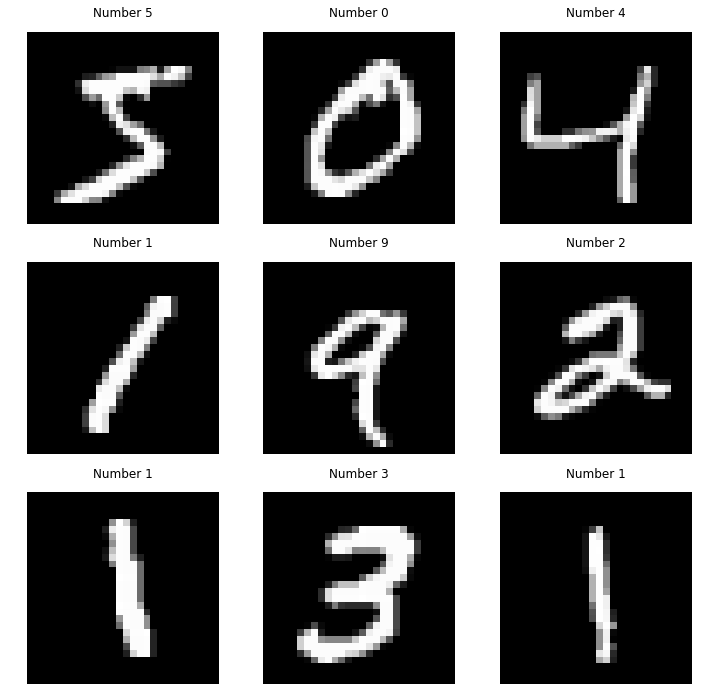

In [5]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [7]:

# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)
print X[0]

(60000L, 784L)
(784L,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        

In [8]:

from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [9]:
kmeans.labels_

array([8, 2, 5, ..., 8, 4, 3])

In [10]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels


In [11]:

# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print predicted_labels[:20]
print Y[:20]

[8 0 4 1 7 2 1 8 1 7 8 1 3 6 1 7 2 8 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [12]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [19]:
clusters = [50,60,256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 50
Inertia: 1876473.71051
Homogeneity: 0.725489451956
Accuracy: 0.7943

Number of Clusters: 60
Inertia: 1835070.2187
Homogeneity: 0.733308333909
Accuracy: 0.798633333333

Number of Clusters: 256
Inertia: 1517507.28859
Homogeneity: 0.843741959002
Accuracy: 0.8998



In [14]:

# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.8981



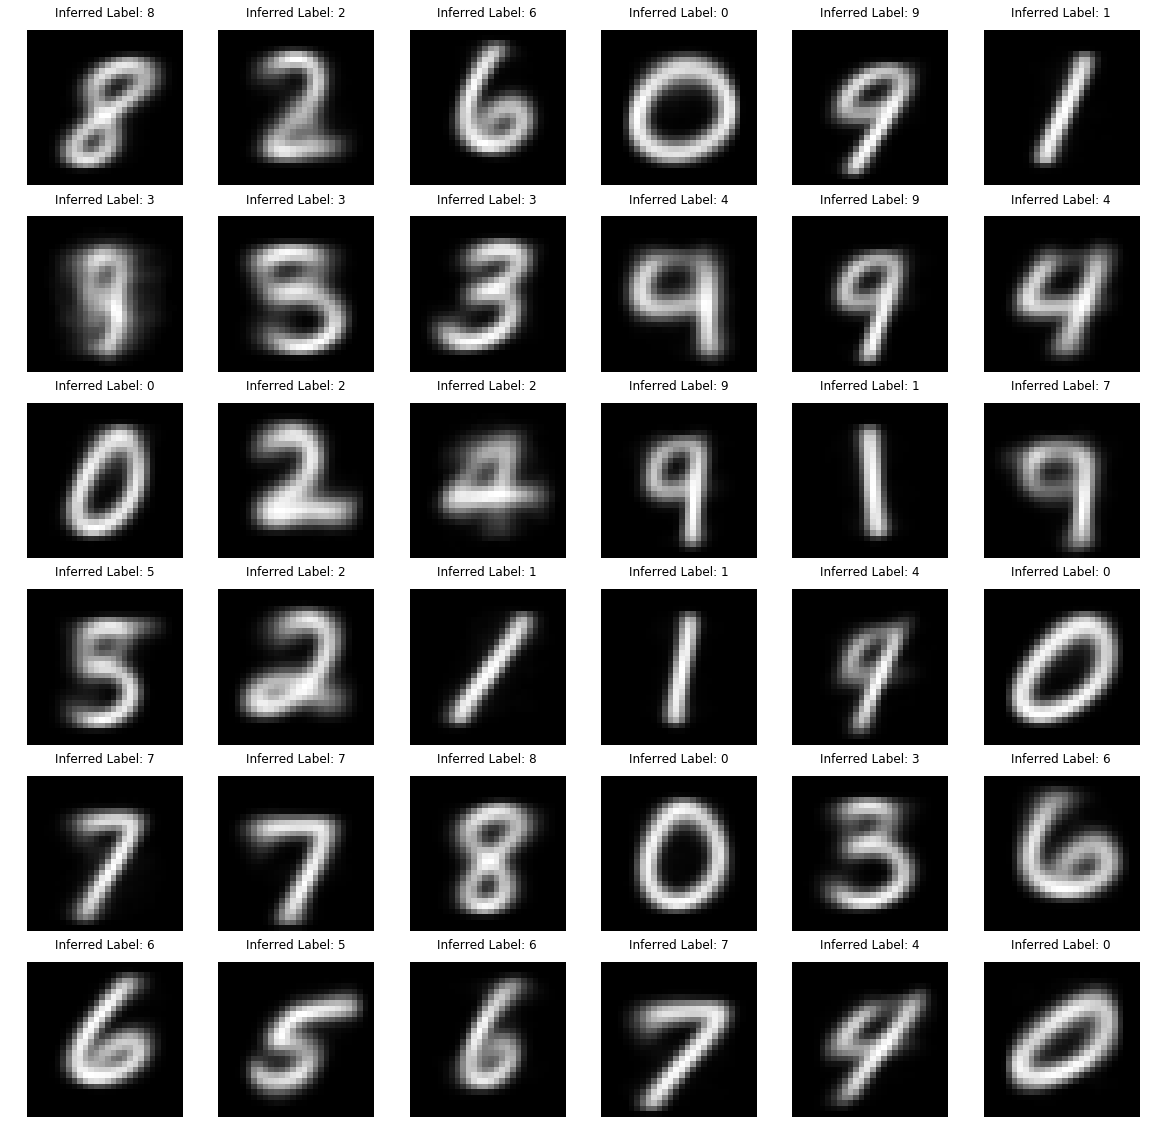

In [15]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()